In [1]:
# Imports
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

from scgpt.tokenizer.gene_tokenizer import GeneVocab

sys.path.append("../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:516"
# os.environ["WANDB_MODE"] = "offline"

c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
# Paths
model_path = "C:/Users/jzuyd/Documents/LACDR/PhD/scRNAseq data/scGPT/scGPT_human"
raw_data_path = "C:/Users/jzuyd/Documents/LACDR/PhD/scRNAseq data/scGPT/CFS/CFS_all_days_rawcount.h5ad"
processed_data_path = "C:/Users/jzuyd/Documents/LACDR/PhD/scRNAseq data/scGPT/CFS/CFS_all_days_processed.h5ad"
day = "CFS_Day0"

In [3]:
raw_data = sc.read_h5ad(raw_data_path)
processed_data = sc.read_h5ad(processed_data_path)
    
# Filter data based on chosen day
subset_raw = raw_data[raw_data.obs['sample'] == day].copy()
subset_processed = processed_data[processed_data.obs['sample'] == day].copy()

# Filter the rawdata object to only contain the genes in the filtered dataset
# Get the common variables (genes) between the two objects
common_vars = np.intersect1d(subset_raw.var_names, subset_processed.var_names)
# Filter to only contain the common variables, output is the input adata for scGPT
adata = subset_raw[:, common_vars].copy()
# Randomly subsample 100 cells from adata
adata = adata[adata.obs.sample(n=100, random_state=42).index]

c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/obs/__categories/sample' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/obs/sample' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\anndata\_io\utils.py:207: OldFormatWarning: Element '/var/_index' was written without encoding metadata.
  return func(*args, **kwargs)


In [4]:
# Hyperparameter settings
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="CFS",
    do_train=True,
    load_model=model_path,
    mask_ratio=0.4,
    epochs=30,
    n_bins=51,
    GEPC=True,  # Masked value prediction for cell embedding
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    lr=1e-4,
    batch_size=2,
    layer_size=128,
    nlayers=4,
    nhead=4,
    # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    log_interval=100,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
)

# Wandb configuration 
run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="thread"), # changed fork to thread for windows compatibility
)
config = wandb.config
print(config)

set_seed(config.seed)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zuijderveltjl (drukkerlab). Use `wandb login --relogin` to force relogin
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\wandb\sdk\lib\ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


{'seed': 42, 'dataset_name': 'CFS', 'do_train': True, 'load_model': 'C:/Users/jzuyd/Documents/LACDR/PhD/scRNAseq data/scGPT/scGPT_human', 'mask_ratio': 0.4, 'epochs': 30, 'n_bins': 51, 'GEPC': True, 'ecs_thres': 0.8, 'dab_weight': 1.0, 'lr': 0.0001, 'batch_size': 2, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True}


In [5]:
# Settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = adata.n_obs # number of highly variable genes, in this case we use all genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

# Settings for logging
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
# save the whole script to the dir
os.system(f"cp {sys.argv[0]} {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save\dev_CFS-May04-23-33


In [6]:
# Loading and preparing data
adata.obs["celltype"] = "CFS_Day0" # change for finetuning with multiple celltypes
adata.obs["str_batch"] = "batch" # change for finetuning with multiple batches
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
adata.var["gene_name"] = adata.var.index
data_is_raw = True

if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size 
    nhead = config.nhead
    nlayers = config.nlayers  
    d_hid = config.layer_size

scGPT - INFO - match 21091/27622 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from C:\Users\jzuyd\Documents\LACDR\PhD\scRNAseq data\scGPT\scGPT_human\best_model.pt, the model args will be overriden by the config C:\Users\jzuyd\Documents\LACDR\PhD\scRNAseq data\scGPT\scGPT_human\args.json.


C:\Users\jzuyd\AppData\Local\Temp\ipykernel_37596\2597399279.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["celltype"] = "CFS_Day0" # change for finetuning with multiple celltypes


In [7]:
# Preprocess data with normalization, log1p and binning
preprocessor = Preprocessor(
    use_key="X",  # The key of :class:`~anndata.AnnData` to use for preprocessing.
    filter_gene_by_counts=False, # Whether to filter genes by counts, if :class:`int`, filter genes with counts.
    filter_cell_by_counts=False, # Whether to filter cells by counts, if :class:`int`, filter cells with counts.
    normalize_total=1e4, # Whether to normalize the total counts of each cell to a specific value.
    result_normed_key="X_normed", # The key of :class:`~anndata.AnnData` to store the normalized data.
    log1p=data_is_raw, # Whether to apply log1p transform to the normalized data.
    result_log1p_key="X_log1p", # The key of :class:`~anndata.AnnData` to store the log1p transformed data.
    #subset_hvg=n_hvg, # Whether to subset highly variable genes.
    #hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins, # Whether to bin the data into discrete values of number of bins provided.
    result_binned_key="X_binned", # The key of :class:`~anndata.AnnData` to store the binned data.
)
preprocessor(adata, batch_key="str_batch")

# Sort the adata by batch_id
if per_seq_batch_sample:
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

# Extract gene expression data, split it into training and validation sets
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.2, shuffle=True, stratify=celltypes_labels
)

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


scGPT - INFO - Binning data ...


In [8]:
# Initialize vocabulary bidirectionally mapping gene symbols to integer IDs 
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

# Tokenize and pad training and validation datasets
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 80, 
	 feature length: 101
scGPT - INFO - valid set number of samples: 20, 
	 feature length: 101


In [9]:
# Function to prepare data for training and validation
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt

In [10]:
# Dataset class for handling sequence data
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# Function to prepare a PyTorch DataLoader for a dataset
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader


In [11]:
# Initialize model, load pre-trained weights, set up loss, optimizer, scheduler, and enable gradient scaling for mixed precision training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)
wandb.watch(model)


criterion = masked_mse_loss
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

Use domain specific batchnorm with affine=False
scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
scGPT - INFO - Loading params transformer_encoder.layers.

In [12]:
# Function to train the model for one epoch
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            metrics_to_log = {"train/mse": loss_mse.item()}
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})
            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )
            if config.ecs_thres > 0:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
            loss = loss + config.dab_weight * loss_dab
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        wandb.log(metrics_to_log)

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


In [13]:
# Function to define metrics for logging during training
def define_wandb_metrcis():
    wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
    wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
    wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
    wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
    wandb.define_metric("test/avg_bio", summary="max")

# Function to evaluate the model on the evaluation data
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/mre": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + config.dab_weight * total_dab)
            / total_num,
            "epoch": epoch,
        },
    )

    return total_loss / total_num, total_error / total_num

In [14]:
# Function to evaluate the model on a test dataset and compute cell embeddings
def eval_testdata(
    model: nn.Module,
    adata_t: AnnData,
    include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)
            
        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig
        
        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["celltype_umap"] = fig

    if len(include_types) == 1:
        return results

random masking at epoch   1, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time:  3.39s | valid loss/mse 183.1100 | mre 4931186.9750
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 183.1100
random masking at epoch   2, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   2 | time:  2.08s | valid loss/mse 126.5133 | mre 1456805.3625
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 126.5133
random masking at epoch   3, ratio of masked values in train:  0.3960
scGPT - INFO - ---------------------------------------------------------------------------

100%|██████████| 50/50 [00:00<00:00, 201.46it/s]
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
scGPT - ERROR - Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\ari.py:86: RuntimeWarning: invalid value encountered in scalar divide
  return (index - expected_index) / (max_index - expected_index)
Traceback (most recent call last):
  File "C:\Users\jzuyd\AppData\Local\Temp\ipykernel_37596\1471029157.py", line 58, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scgpt\utils\util.py", line 376, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py", line 329, in metrics
    asw_label = silhouette(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\_utils\__init__.py", line 153, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\silhouette.py", line 49, in silhouette
    asw = silhouette_score(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\

random masking at epoch   6, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   6 | time:  2.41s | valid loss/mse 105.1634 | mre 2083354.6625
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 105.1634
random masking at epoch   7, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   7 | time:  2.20s | valid loss/mse 107.5567 | mre 1402106.2375
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch   8, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  

100%|██████████| 50/50 [00:00<00:00, 191.23it/s]
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
scGPT - ERROR - Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\ari.py:86: RuntimeWarning: invalid value encountered in scalar divide
  return (index - expected_index) / (max_index - expected_index)
Traceback (most recent call last):
  File "C:\Users\jzuyd\AppData\Local\Temp\ipykernel_37596\1471029157.py", line 58, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scgpt\utils\util.py", line 376, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py", line 329, in metrics
    asw_label = silhouette(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\_utils\__init__.py", line 153, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\silhouette.py", line 49, in silhouette
    asw = silhouette_score(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\

random masking at epoch  11, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  11 | time:  2.15s | valid loss/mse 106.6866 | mre 2391071.7000
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  12, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  12 | time:  2.13s | valid loss/mse 109.3710 | mre 2214697.4000
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  13, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  13 | time:  2.13s | valid loss/mse 104.0913 | 

100%|██████████| 50/50 [00:00<00:00, 198.17it/s]
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
scGPT - ERROR - Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\ari.py:86: RuntimeWarning: invalid value encountered in scalar divide
  return (index - expected_index) / (max_index - expected_index)
Traceback (most recent call last):
  File "C:\Users\jzuyd\AppData\Local\Temp\ipykernel_37596\1471029157.py", line 58, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scgpt\utils\util.py", line 376, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py", line 329, in metrics
    asw_label = silhouette(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\_utils\__init__.py", line 153, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\silhouette.py", line 49, in silhouette
    asw = silhouette_score(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\

random masking at epoch  16, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  16 | time:  2.13s | valid loss/mse 96.1096 | mre 1916016.0250
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 96.1096
random masking at epoch  17, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  17 | time:  2.09s | valid loss/mse 91.2208 | mre 1639723.4500
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 91.2208
random masking at epoch  18, ratio of masked values in train:  0.3960
scGPT - INFO - -------------------------------------------------------------------------------

100%|██████████| 50/50 [00:00<00:00, 173.93it/s]
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
scGPT - ERROR - Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\ari.py:86: RuntimeWarning: invalid value encountered in scalar divide
  return (index - expected_index) / (max_index - expected_index)
Traceback (most recent call last):
  File "C:\Users\jzuyd\AppData\Local\Temp\ipykernel_37596\1471029157.py", line 58, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scgpt\utils\util.py", line 376, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py", line 329, in metrics
    asw_label = silhouette(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\_utils\__init__.py", line 153, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\silhouette.py", line 49, in silhouette
    asw = silhouette_score(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\

random masking at epoch  21, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  21 | time:  2.12s | valid loss/mse 107.8306 | mre 2070101.7437
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  22, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  22 | time:  1.99s | valid loss/mse 113.5735 | mre 2335424.8312
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  23, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  23 | time:  2.09s | valid loss/mse 113.9750 | 

100%|██████████| 50/50 [00:00<00:00, 189.68it/s]
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
scGPT - ERROR - Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\ari.py:86: RuntimeWarning: invalid value encountered in scalar divide
  return (index - expected_index) / (max_index - expected_index)
Traceback (most recent call last):
  File "C:\Users\jzuyd\AppData\Local\Temp\ipykernel_37596\1471029157.py", line 58, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scgpt\utils\util.py", line 376, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py", line 329, in metrics
    asw_label = silhouette(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\_utils\__init__.py", line 153, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\silhouette.py", line 49, in silhouette
    asw = silhouette_score(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\

random masking at epoch  26, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  26 | time:  2.06s | valid loss/mse 111.3414 | mre 1881158.8250
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  27, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  27 | time:  1.99s | valid loss/mse 111.5317 | mre 1862268.9563
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  28, ratio of masked values in train:  0.3960
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  28 | time:  1.97s | valid loss/mse 100.3662 | 

100%|██████████| 50/50 [00:00<00:00, 172.82it/s]
c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
scGPT - ERROR - Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\ari.py:86: RuntimeWarning: invalid value encountered in scalar divide
  return (index - expected_index) / (max_index - expected_index)
Traceback (most recent call last):
  File "C:\Users\jzuyd\AppData\Local\Temp\ipykernel_37596\1471029157.py", line 58, in eval_testdata
    results = eval_scib_metrics(adata_t)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scgpt\utils\util.py", line 376, in eval_scib_metrics
    results = scib.metrics.metrics(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\metrics.py", line 329, in metrics
    asw_label = silhouette(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scanpy\_utils\__init__.py", line 153, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\scib\metrics\silhouette.py", line 49, in silhouette
    asw = silhouette_score(
  File "c:\Users\jzuyd\anaconda3\envs\scgpt\lib\

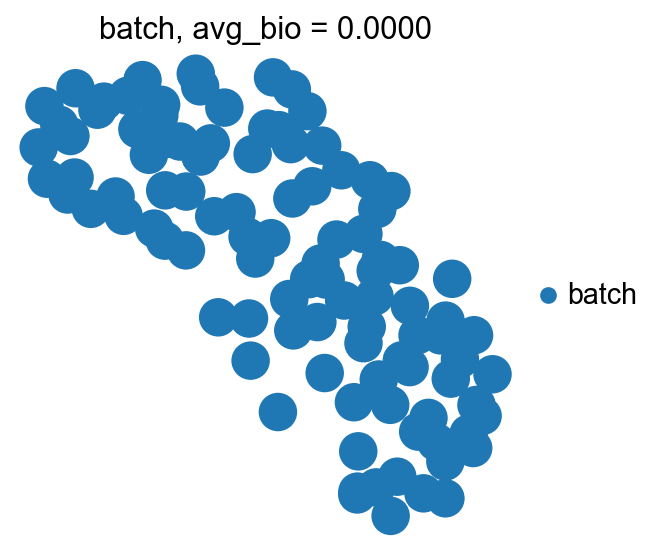

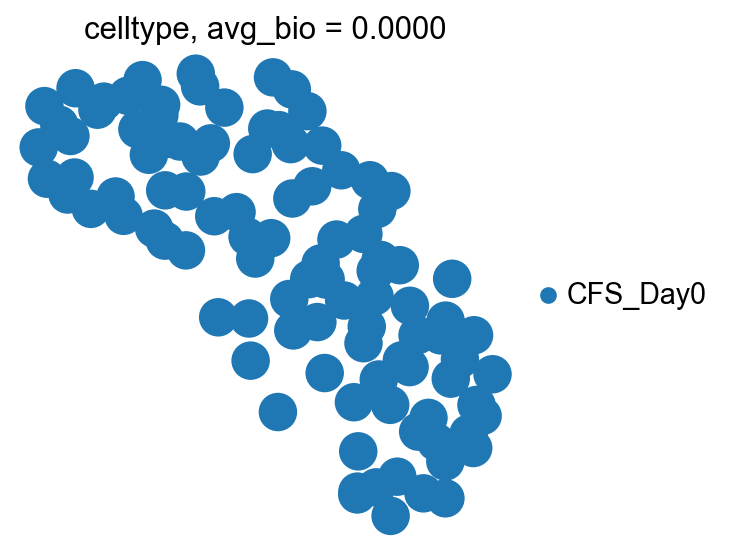

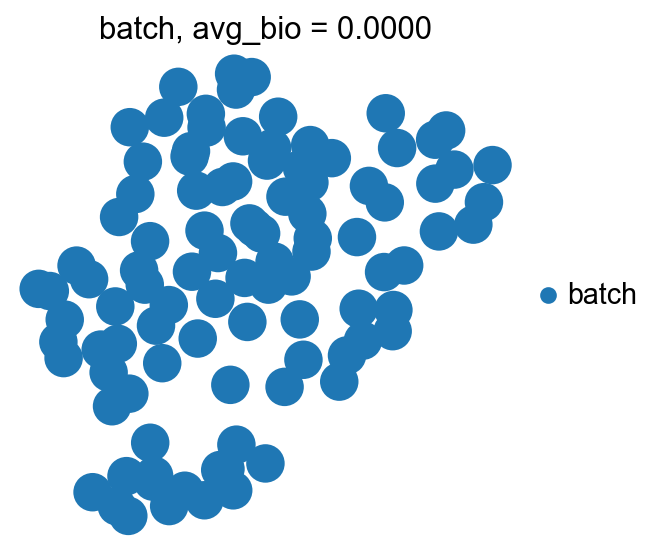

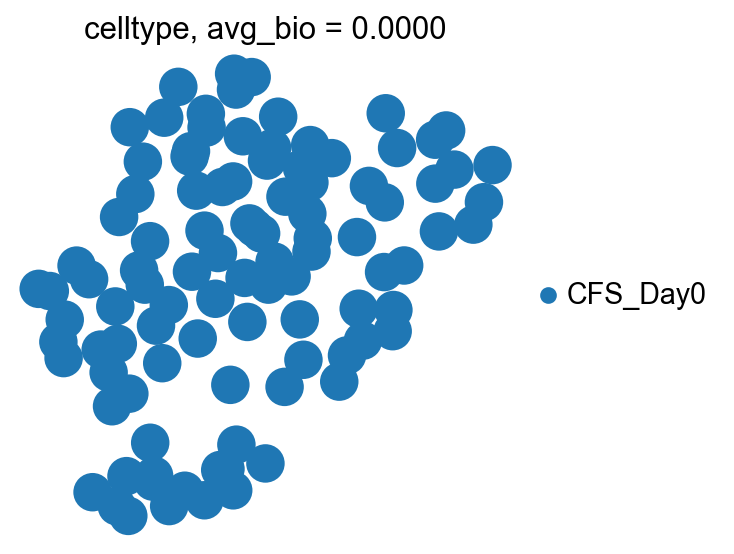

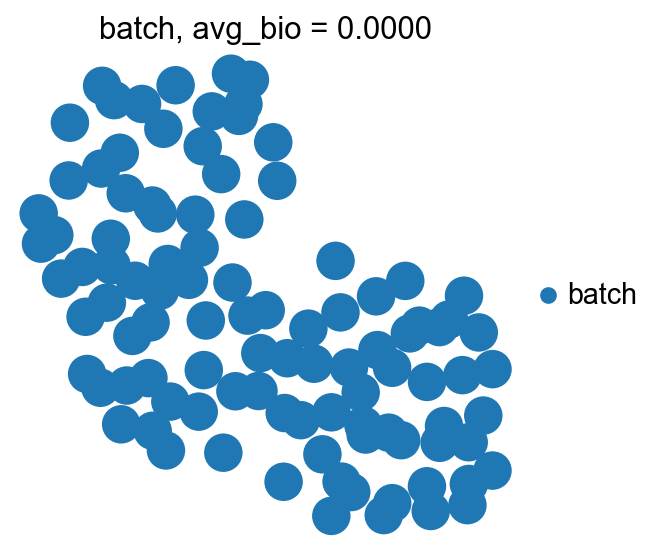

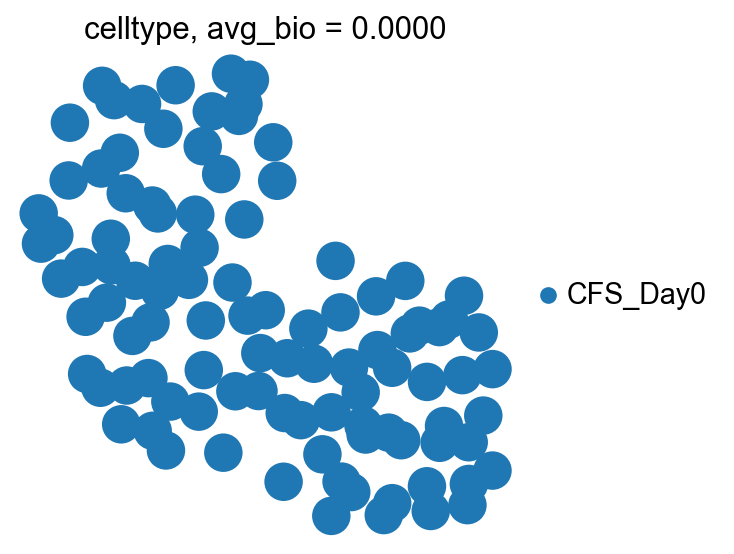

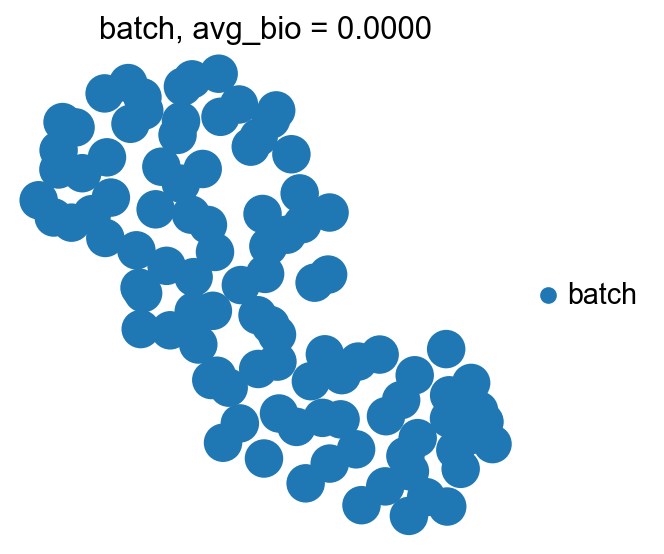

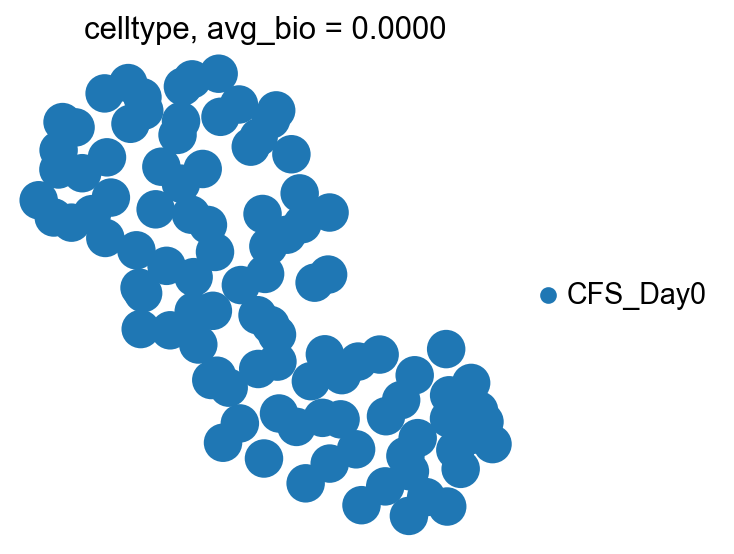

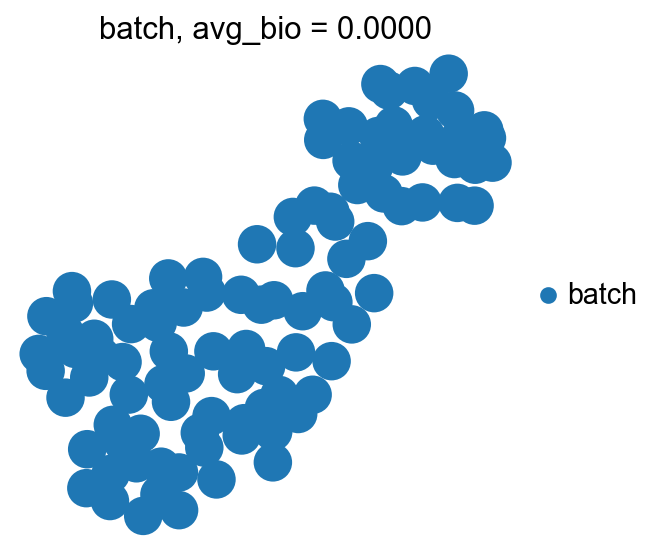

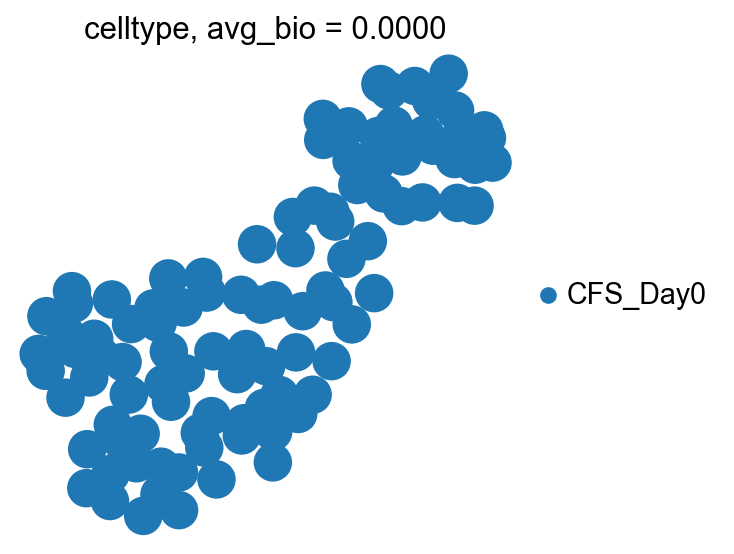

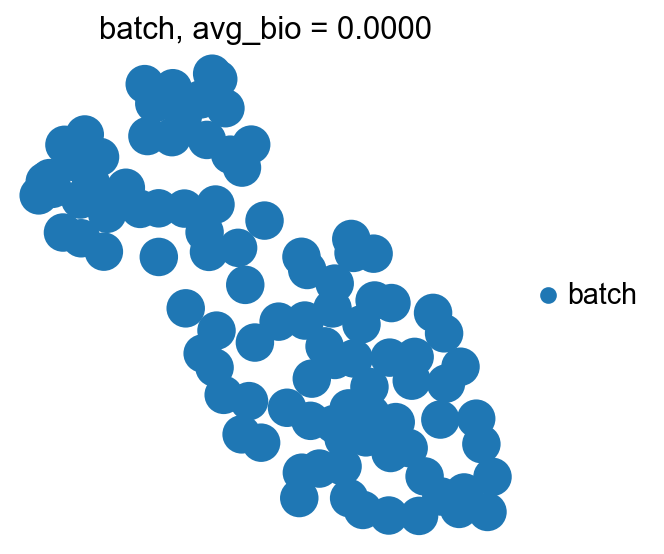

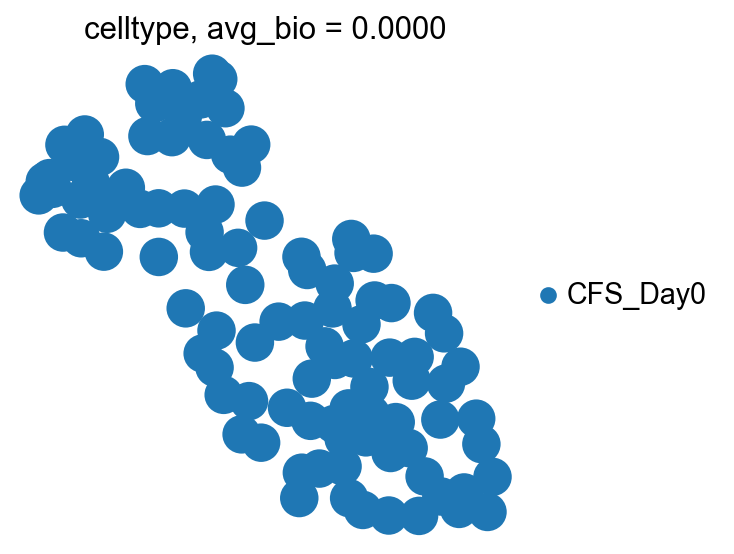

In [15]:
# Training loop to iterate through epochs, evaluate model performance, and save the best model
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            best_model,
            adata_t=adata_sorted if per_seq_batch_sample else adata,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/celltype_umap"] = wandb.Image(
            str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()

In [16]:
# Save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()


c:\Users\jzuyd\anaconda3\envs\scgpt\lib\site-packages\wandb\sdk\lib\ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


avg_bio,▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test/best_model_epoch,▁▄▄███
train/dab,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/ecs,▁▃▂▇▇▄▆▆▅▅▇▄▄▄▅▆▆▆▅▅▄▇▆▅▅▇▅▃▆█▆▄▅▆█▄▅▄▆▇
train/mse,▆██▄▄▂▃▃▃▂▂▂▃▁▃▂▃▂▄▁▂▃▂▁▂▂▁▁▁▁▂▃▂▁▁▁▁▂▁▁
train/mvc,█▆▄▃▅▃▃▃▂▂▂▃▃▂▄▂▃▃▄▂▂▃▂▂▂▁▁▂▁▂▂▄▂▁▁▂▂▃▁▁
train/mvc_nzlp,▆▆▅▃█▅▆▆▂▃▇▁▅▂▄▃▄▅▆▃▃▃▄▂▃▂▂▂▁▂▂▄▃▃▂▄▂▂▃▃
train/nzlp,█▇▇▅▇▃▅▄▄▅▅▃▇▃▅▄▅▄▆▂▄▄▆▅▃▄▂▂▂▃▃▄▅▂▂▃▁▃▁▃
valid/dab,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid/mre,█▁▂▅▁▃▁▂▂▂▃▃▃▃▂▂▂▃▂▃▃▃▂▂▂▂▂▃▂▃


86330